# Algoritmo de grover


#### Autor: Fernando Ares Robledo
#### email: fernandoaresrobledo@gmail.com


#### Ultima fecha de modificacion: 7 de mayo de 2023

Entrada aleatoria: 0100
Número de iteraciones requeridas es:  3


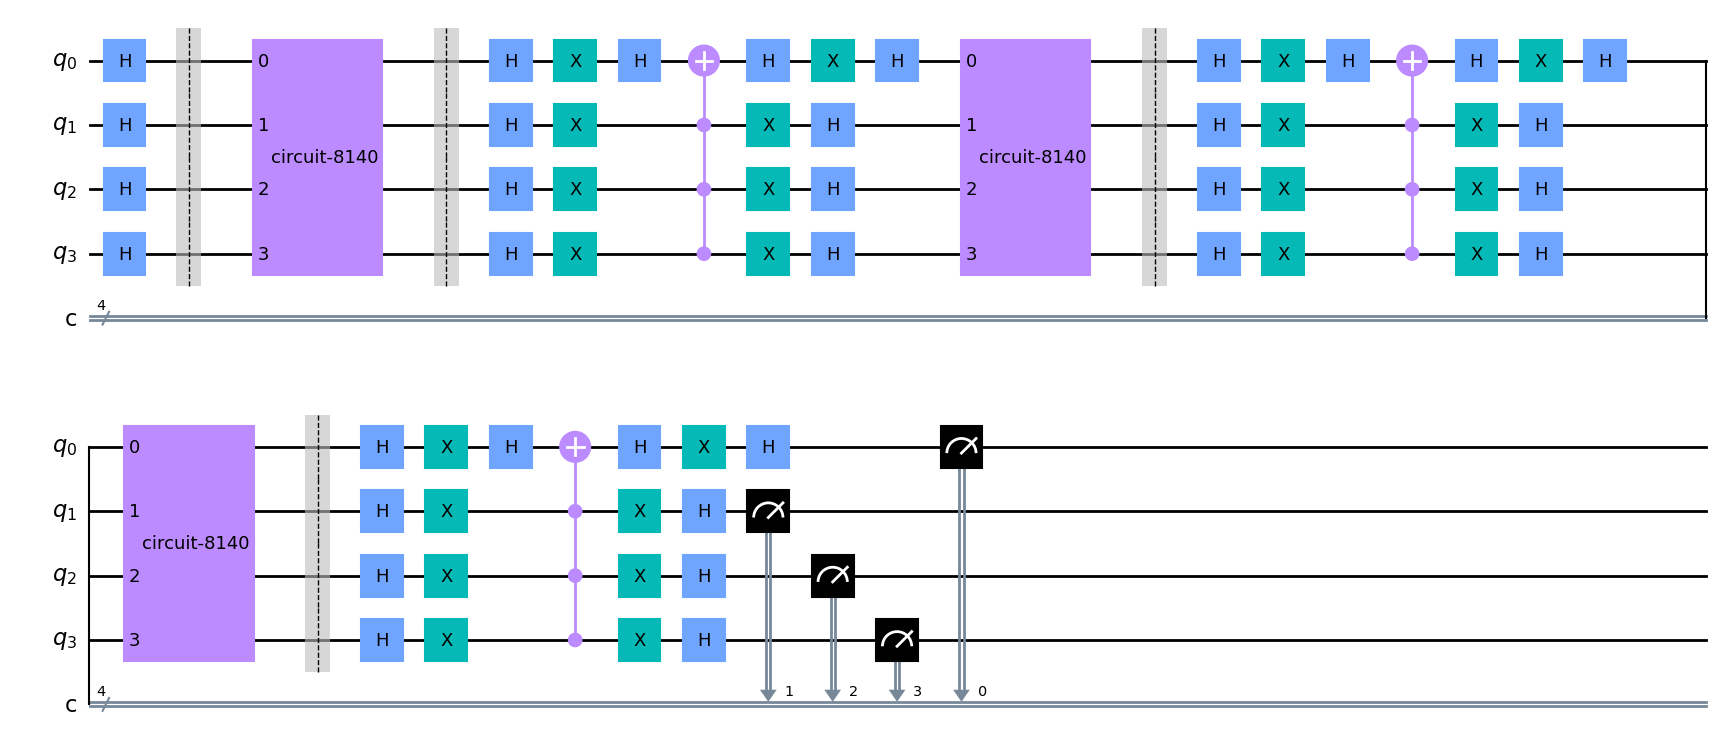

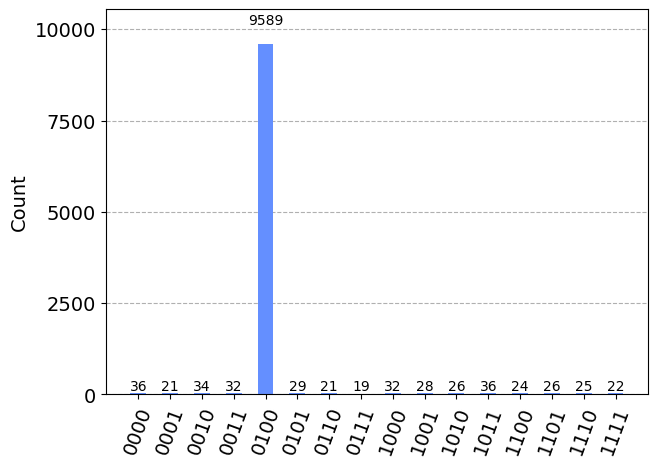

In [14]:
# -*- coding: utf-8 -*-

"""
Nombre del archivo: grover.ipynb

Descripción: Este código implementa el algoritmo cuántico de búsqueda de Grover 
utilizando la biblioteca Qiskit. La clase GroverCuantico contiene funciones para crear y ejecutar un 
circuito cuántico que implementa el algoritmo de Grover. 


Autor: Fernando Ares Robledo
Fecha de creación: 28/02/2023
"""

import numpy as np
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from IPython.display import display
from qiskit.providers.aer import StatevectorSimulator
from qiskit.providers.fake_provider import FakeJakarta,FakeVigo,FakeNairobi
from qiskit_aer import AerSimulator
import random


class GroverCuantico:
    def __init__(self, n):
        """
        Clase que implementa el algoritmo de búsqueda de Grover en un circuito cuántico.

        Args:
            n (int): Número de qubits en el circuito.
        """
        self.n = n

    def grover_oraculo(self, entrada):
        """
        Crea el circuito cuántico correspondiente al oráculo de Grover.

        Args:
            entrada (str): Cadena de bits que representa la entrada del oráculo.

        Returns:
            QuantumCircuit: Objeto que representa el circuito cuántico del oráculo.
        """
        if not self.validar_entrada(entrada):
            raise ValueError("La entrada del oráculo es inválida.")
            
        circuito = QuantumCircuit(self.n)
        
        # Configuración de los qubits según la entrada
        [circuito.x(self.n - i - 1) for i in range(self.n) if entrada[i] == '0']

        # Aplicación de la transformada de Hadamard al primer qubit
        circuito.h(0)

        # Aplicación de la compuerta MCX (Multiple-Controlled X) a los qubits restantes con el primer qubit como control
        circuito.mcx([i for i in range(1, self.n)], 0)

        # Aplicación de la transformada de Hadamard al primer qubit nuevamente
        circuito.h(0)
        
        # Inversión de los qubits según la entrada
        [circuito.x(self.n - i - 1) for i in range(len(entrada)) if entrada[i] == '0']

        return circuito
    
    def validar_entrada(self, entrada):
        """
        Valida la entrada del oráculo de Grover.

        Args:
            entrada (str): Cadena de bits que representa la entrada del oráculo.

        Returns:
            bool: True si la entrada es válida, False en caso contrario.
        """
        if len(entrada) != self.n:
            return False

        for bit in entrada:
            if bit not in ('0', '1'):
                return False

        return True


    def calcular_num_iteraciones(self):
        """
        Calcula el número de iteraciones necesarias para el algoritmo de Grover.

        Returns:
            int: Número de iteraciones necesarias.
        """
        n_iteraciones = int(np.round(np.pi * np.sqrt(2 ** self.n) / 4 - 0.5))
        #aproximadamente proporcional a la raíz cuadrada del tamaño del espacio de búsqueda
        print("Número de iteraciones requeridas es: ",n_iteraciones)
        return n_iteraciones

    def crear_circuito_grover(self, oraculo):
        """
        Crea el circuito cuántico que implementa el algoritmo de búsqueda de Grover.

        Args:
            oraculo (QuantumCircuit): Objeto que representa el circuito cuántico del oráculo.

        Returns:
            QuantumCircuit: Objeto que representa el circuito cuántico de la función de Grover.
        """
        circuito = QuantumCircuit(self.n, self.n)

        n_iteraciones = self.calcular_num_iteraciones()
        
        # Aplicación de la transformada de Hadamard a todos los qubits
        circuito.h(range(self.n))
        circuito.barrier()
        
        for _ in range(n_iteraciones):
            # Aplicación del oráculo
            circuito.append(oraculo, range(self.n))
            circuito.barrier()

            # Fase de difusión
            circuito.h(range(self.n))
            circuito.x(range(self.n))
            circuito.h(0)
            
            # Aplicación de la compuerta MCX a los qubits restantes con el primer qubit como control
            cubits = [i + 1 for i in range(self.n - 1)]
            circuito.mcx(cubits, 0)
            circuito.h(0)

            # Inversión de los qubits
            circuito.x(range(self.n))
            circuito.h(range(self.n))


        circuito.measure(range(self.n), range(self.n))
            
        return circuito




    def visualizar_circuito(self, circuito):
        """
        Visualiza el circuito cuántico utilizando la librería matplotlib.

        Args:
            circuito (QuantumCircuit): Objeto que representa el circuito cuántico a visualizar.
        """
        display(circuito.draw("mpl"))

    def ver_histograma(self, resultado):
        """
        Visualiza el histograma de los resultados de la medición del circuito cuántico.

        Args:
            resultado (dict): Diccionario que contiene la información de los resultados de la medición.
        """
        display(plot_histogram(resultado))

    def generar_entrada_aleatoria(self):
        """
        Genera una entrada aleatoria para el oráculo de Grover.

        Returns:
            str: Cadena de bits que representa la entrada del oráculo.
        """
        entrada = ""
        for _ in range(self.n):
            entrada += str(random.randint(0, 1))
        return entrada

# Ejemplo de uso
n = 4
grover = GroverCuantico(n)

# Generar una entrada aleatoria
entrada_aleatoria = grover.generar_entrada_aleatoria()
print("Entrada aleatoria:", entrada_aleatoria)

# Crear el circuito del oráculo para la entrada aleatoria
oraculo = grover.grover_oraculo(entrada_aleatoria)

# Crear el circuito de Grover para el oráculo
circuito = grover.crear_circuito_grover(oraculo)

grover.visualizar_circuito(circuito)
simulador = AerSimulator.from_backend(FakeJakarta())
simulador = QasmSimulator()
#simulador = AerSimulator.from_backend(FakeVigo())
#simulador = StatevectorSimulator()

resultado = execute(circuito, simulador, shots=10000).result().get_counts()
grover.ver_histograma(resultado)
